In [36]:
import numpy as np
import csv
import sys
import os

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [37]:
def plot_througput(data, label, do_plot=True):
    """
    Throughput speed in Mbps
    """
    times = data[:,0]
    throughputs = data[:,1]
    throughputs = np.trim_zeros(throughputs, trim='b')
    times = times[:throughputs.shape[0]]
    throughputs = np.trim_zeros(throughputs, trim='f')
    times = times[times.shape[0] - throughputs.shape[0]:]
        
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(times, throughputs, label="throughput "+label) 
        ax1.set_title("Throughput vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Mbps')
        ax1.set_xlabel('Simulation Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("throughput vs Time.png", format="png")
        fig.show()
    return np.mean(throughputs), np.percentile(throughputs, 99)

In [38]:
def plot_cwnd(data, label, do_plot=True):
    times = data[:,0]
    throughputs = data[:,1]
    cwnds = data[:,2]
    throughputs = np.trim_zeros(throughputs, trim='b')
    times = times[:throughputs.shape[0]]
    cwnds = cwnds[:throughputs.shape[0]]
    
    throughputs = np.trim_zeros(throughputs, trim='f')
    times = times[times.shape[0] - throughputs.shape[0]:]
    cwnds = cwnds[cwnds.shape[0] - throughputs.shape[0]:]
    
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(times, cwnds, label="cwnd "+label) 
        ax1.set_title("Cwnd vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Packets')
        ax1.set_xlabel('Simulation Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("cwnd vs Time.png", format="png")
        fig.show()
    return np.mean(cwnds)

In [39]:
def plot_queue_size(data, label, do_plot=True):
    
    # http://www.mathcs.emory.edu/~cheung/Courses/558-old/Syllabus/90-NS/trace.html
    # Columns are: Time(s)-fromNode-toNode-SizeB-SizePack-Packsarrived(in interval)
    # -departed - dropped -3: same in bytes
    times = data[:,0]
    q_size_B, q_size_P = data[:,3], data[:,4]
    q_size_B = np.trim_zeros(q_size_B, trim='b')
    q_size_P = np.trim_zeros(q_size_P, trim='b')
    times = times[:q_size_B.shape[0]]
    
    q_size_B = np.trim_zeros(q_size_B, trim='f')
    q_size_P = np.trim_zeros(q_size_P, trim='f')
    
    times = times[times.shape[0] - q_size_B.shape[0]:]
    
    if do_plot:
        fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
        ax1.plot(times, q_size_B, label="q_size in bytes "+label) 
        ax1.set_title("Q size vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Bytes')
        ax1.set_xlabel('Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        ax2.plot(times, q_size_P, label="q_size in packets "+label) 
        ax2.set_title("Q size vs Time")
        ax2.legend(loc='upper left')
        ax2.set_ylabel('Packets')
        ax2.set_xlabel('Seconds')
        ax2.grid(which='major', linestyle="-")
        ax2.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Q_size vs Time.png", format="png")
        fig.show()
    #avg_q_occup = np.mean(q_size_B)
    #print("Mon_mean: " + str(avg_q_occup))
    q_size_B = q_size_B/1000.0
    return np.mean(q_size_B), np.mean(q_size_P), np.percentile(q_size_B,99), np.percentile(q_size_P, 99)

In [40]:
def plot_queuing_time(data, label, link_speed, do_plot=True):
    """
    Link speed in Gbps
    """
    times = data[:,0]
    q_size_B, q_size_P = data[:,3], data[:,4]
    q_size_B = np.trim_zeros(q_size_B, trim='b')
    times = times[:q_size_B.shape[0]]
    q_size_B = np.trim_zeros(q_size_B, trim='f')
    times = times[times.shape[0] - q_size_B.shape[0]:]
    
    link_speed = link_speed * 1000.0 * 1000.0 * 1000.0
    q_time = q_size_B/(link_speed/8.0) * 1000.0 * 1000.0
    
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(times, q_time, label="queuing delay "+label) 
        ax1.set_title("Queuing delay vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Queuing miliseconds')
        ax1.set_xlabel('Simulation Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(q_time), np.percentile(q_time, 99)

In [41]:
def print_results():
    print("Mean Q length in Kbytes {0} and in packets {1}\n\
    99th percentile in Kbytes {2} and in packets {3}\n".format(bytes_mean, pkts_mean, bytes_99, pkts_99))
    print("Mean delay in us {0} and 99th percentile delay in us {1}".format(delay_mean, delay_99))
    print("Mean thrpt in Mbps {0} and 99th percentile thrpt in Mbps {1}".format(thrpt_mean, thrpt_99))    

In [42]:
thrpt_list = [None]*4
delay_mean_list = [None]*4
delay_99_list = [None]*4

# TCP

Mean Q length in Kbytes 128.11275597553976 and in packets 200.1761815878975
    99th percentile in Kbytes 319.34003199995504 and in packets 498.96879999992984

Mean delay in us 1024.9020478043183 and 99th percentile delay in us 2554.720255999641
Mean thrpt in Mbps 754.436911487759 and 99th percentile thrpt in Mbps 950.4


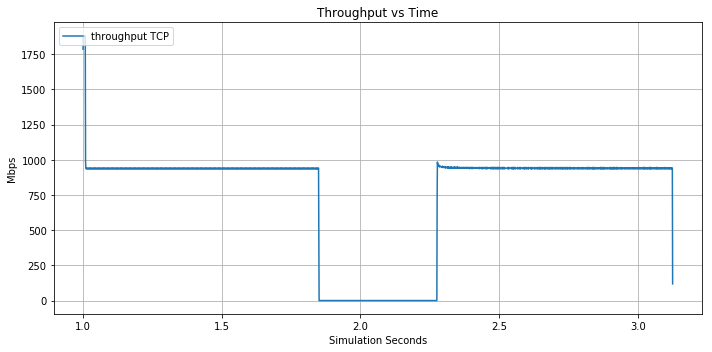

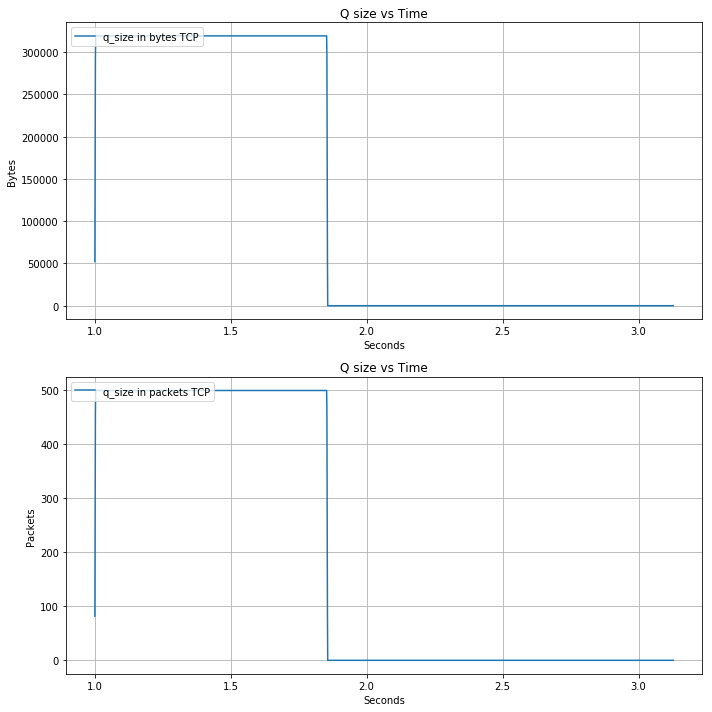

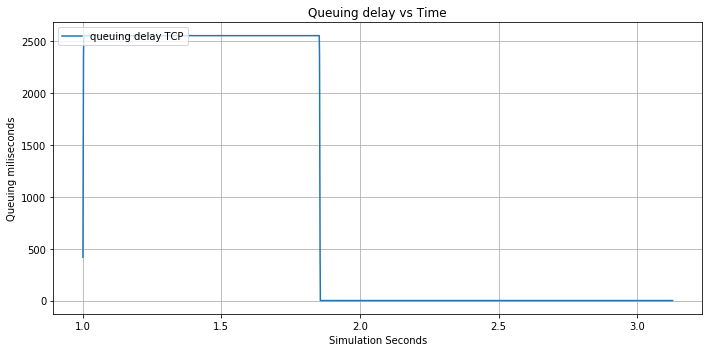

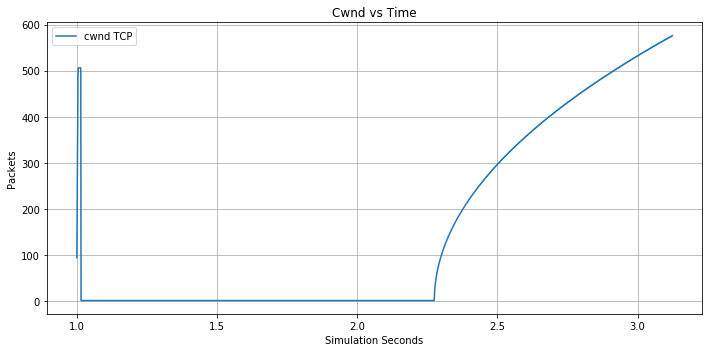

In [43]:
label = "TCP"
q_mon = np.genfromtxt("q_mon|"+label+"|2", delimiter=" ")
thrpts =np.genfromtxt("thrpt_mon|"+label+"|2", delimiter=",")

thrpt_mean, thrpt_99 = plot_througput(thrpts, label)
bytes_mean, pkts_mean, bytes_99, pkts_99 = plot_queue_size(q_mon, label)
delay_mean, delay_99 = plot_queuing_time(q_mon, label, 1)
plot_cwnd(thrpts,label)
print_results()

thrpt_list[0] = thrpt_mean
delay_mean_list[0] = delay_mean
delay_99_list[0] = delay_99


# DCTCP - 30K

Mean Q length in Kbytes 30.066239677365605 and in packets 46.97856393642272
    99th percentile in Kbytes 30.388633600012376 and in packets 47.48224000001934

Mean delay in us 240.52991741892484 and 99th percentile delay in us 243.109068800099
Mean thrpt in Mbps 937.3169302870533 and 99th percentile thrpt in Mbps 950.4000000000001


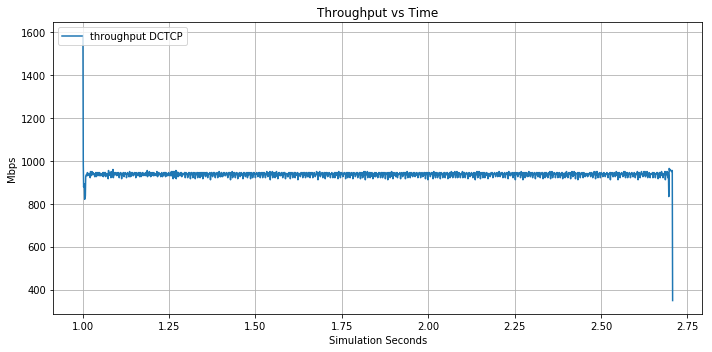

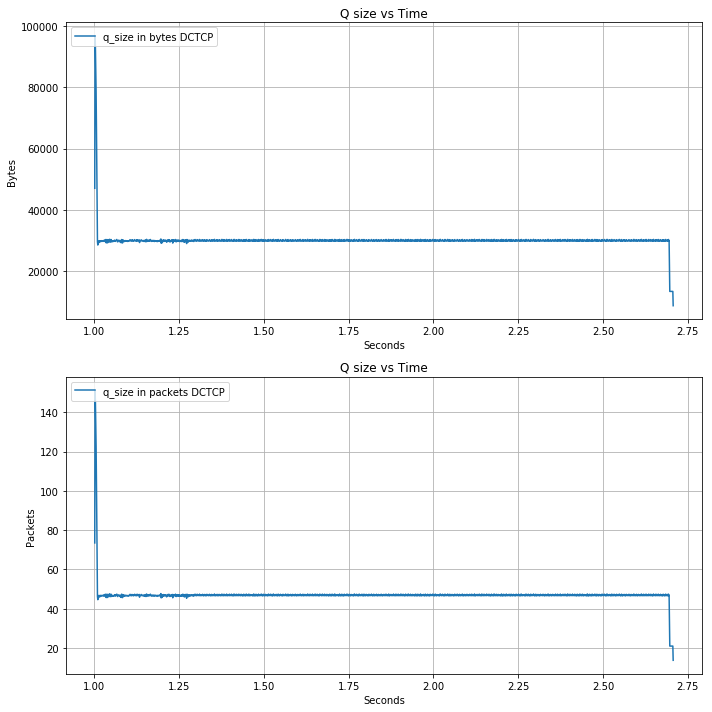

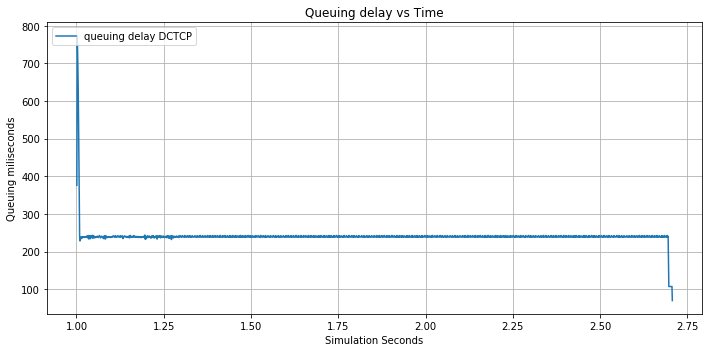

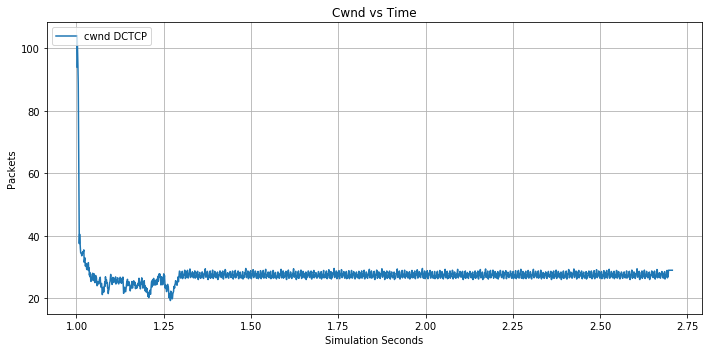

In [44]:
label = "DCTCP"
q_mon = np.genfromtxt("q_mon|"+label+"|2", delimiter=" ")
thrpts =np.genfromtxt("thrpt_mon|"+label+"|2", delimiter=",")

thrpt_mean, thrpt_99 = plot_througput(thrpts, label)
bytes_mean, pkts_mean, bytes_99, pkts_99 = plot_queue_size(q_mon, label)
delay_mean, delay_99 = plot_queuing_time(q_mon, label, 1)
plot_cwnd(thrpts,label)

print_results()

thrpt_list[1] = thrpt_mean
delay_mean_list[1] = delay_mean
delay_99_list[1] = delay_99

# DCTCP - 6K + Pacing

Mean Q length in Kbytes 11.62899493210732 and in packets 18.170342607583784
    99th percentile in Kbytes 49.872664565341026 and in packets 77.92603838334536

Mean delay in us 93.03195945685856 and 99th percentile delay in us 398.9813165227282
Mean thrpt in Mbps 910.1251422070535 and 99th percentile thrpt in Mbps 998.4


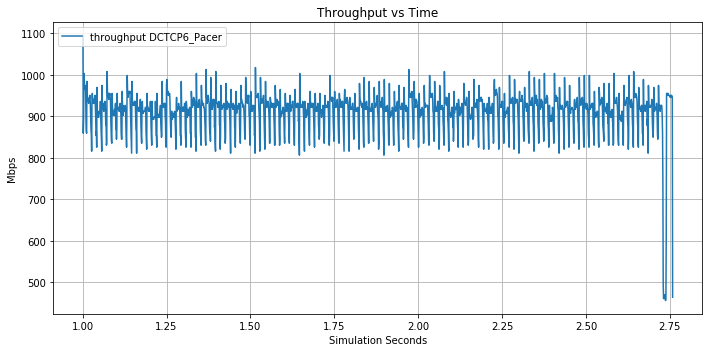

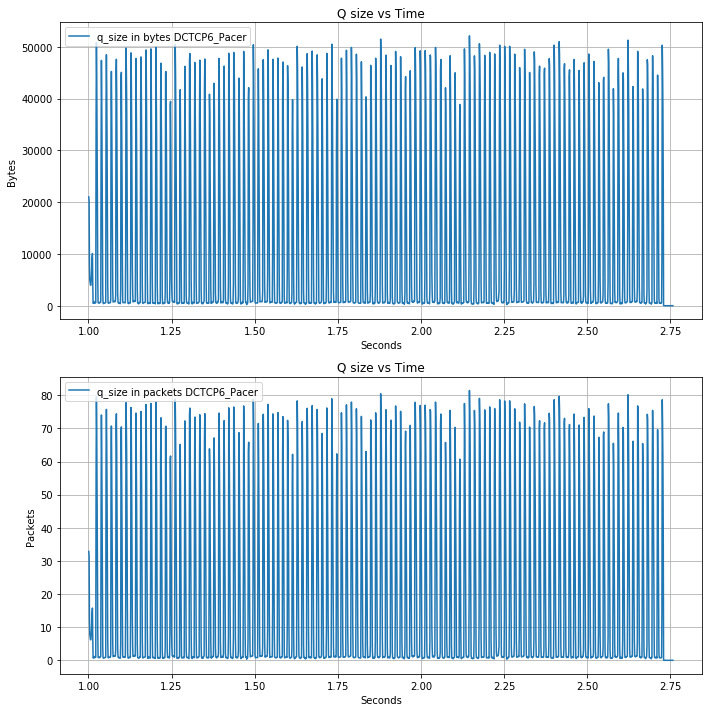

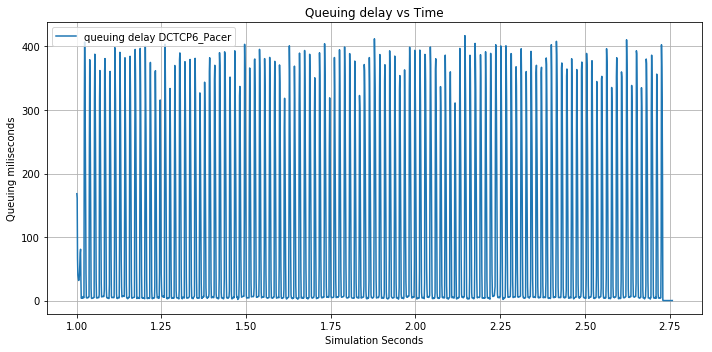

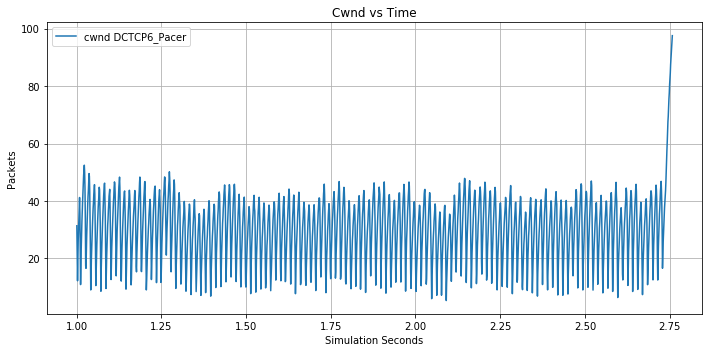

In [45]:
label = "DCTCP6_Pacer"
q_mon = np.genfromtxt("q_mon|"+label+"|2", delimiter=" ")
thrpts =np.genfromtxt("thrpt_mon|"+label+"|2", delimiter=",")

thrpt_mean, thrpt_99 = plot_througput(thrpts, label)
bytes_mean, pkts_mean, bytes_99, pkts_99 = plot_queue_size(q_mon, label)
delay_mean, delay_99 = plot_queuing_time(q_mon, label, 1)
plot_cwnd(thrpts,label)

print_results()

thrpt_list[2] = thrpt_mean
delay_mean_list[2] = delay_mean
delay_99_list[2] = delay_99

# DCTCP + PQ950 + Pacing

3.4060690587649405
Mean Q length in Kbytes 0.15808939447132278 and in packets 0.24701507726781638
    99th percentile in Kbytes 0.2643675093776788 and in packets 0.4130742334026231

Mean delay in us 1.2647151557705822 and 99th percentile delay in us 2.1149400750214307
Mean thrpt in Mbps 796.8127490039841 and 99th percentile thrpt in Mbps 816.0


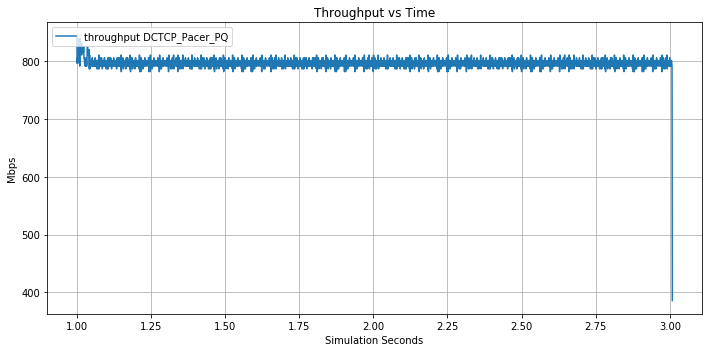

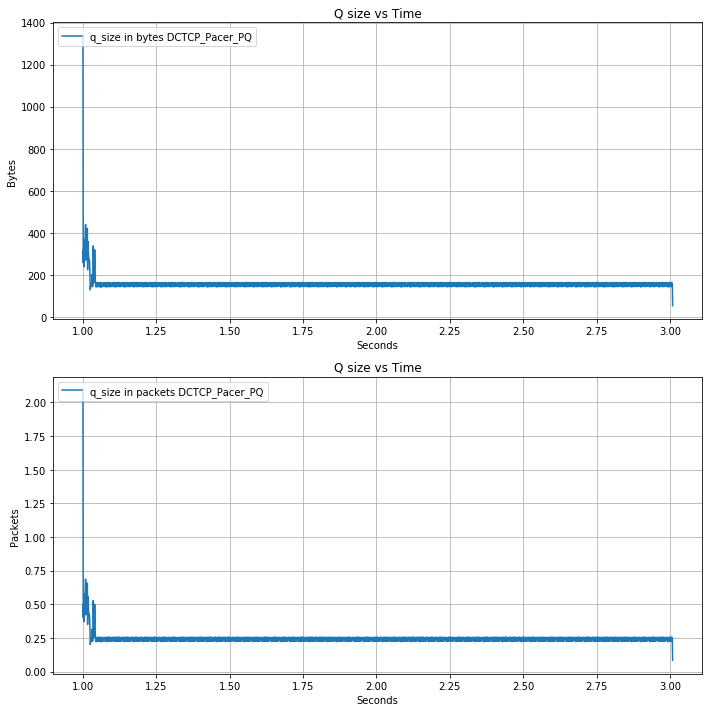

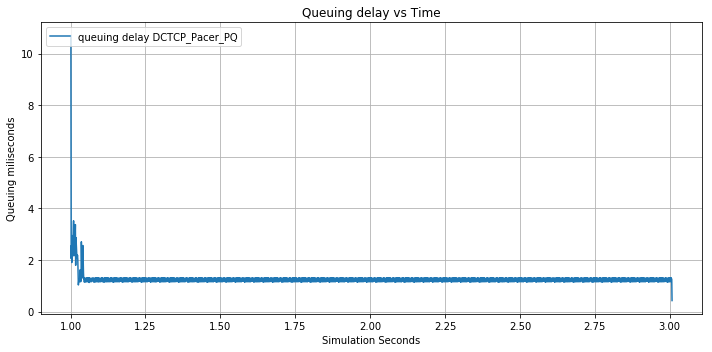

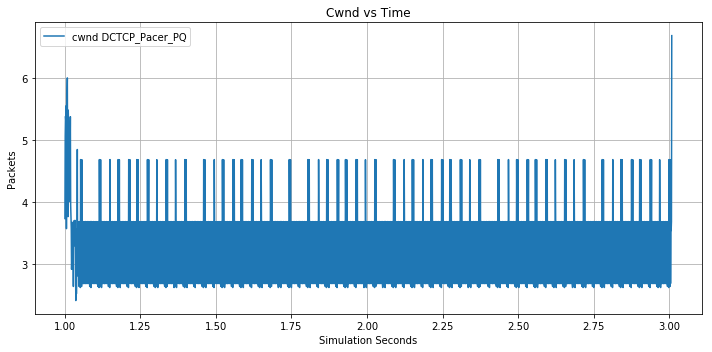

In [46]:
label = "DCTCP_Pacer_PQ"
q_mon = np.genfromtxt("q_mon|"+label+"|2", delimiter=" ")
thrpts =np.genfromtxt("thrpt_mon|"+label+"|2", delimiter=",")
thrpt_mean, thrpt_99 = plot_througput(thrpts, label)
bytes_mean, pkts_mean, bytes_99, pkts_99 = plot_queue_size(q_mon, label)
delay_mean, delay_99 = plot_queuing_time(q_mon, label, 1)
wnd_avg = plot_cwnd(thrpts,label)
print(wnd_avg)
print_results()

thrpt_list[3] = thrpt_mean
delay_mean_list[3] = delay_mean
delay_99_list[3] = delay_99

# AGGREAGTES

In [47]:
print(delay_mean_list)
print(delay_99_list)
print(thrpt_list)

[1024.9020478043183, 240.52991741892484, 93.03195945685856, 1.2647151557705822]
[2554.720255999641, 243.109068800099, 398.9813165227282, 2.1149400750214307]
[754.436911487759, 937.3169302870533, 910.1251422070535, 796.8127490039841]


In [48]:
nums_flows = [2,3,4,5,6,7,8]
labels = ["TCP","DCTCP","DCTCP6_Pacer","DCTCP_Pacer_PQ"]
delay_results = np.zeros(shape=(len(labels), len(nums_flows)))
delay_results_99 = np.zeros(shape=(len(labels), len(nums_flows)))
throughput_results = np.zeros(shape=(len(labels), len(nums_flows)))

for col,num_flows in enumerate(nums_flows):
    for row,label in enumerate(labels):
        file_suffix = label+"|"+str(num_flows)
        print(file_suffix)
        q_mon = np.genfromtxt("q_mon|"+file_suffix, delimiter=" ")
        thrpts =np.genfromtxt("thrpt_mon|"+file_suffix, delimiter=",")

        thrpt_mean, thrpt_99 = plot_througput(thrpts, label, do_plot=False)
        delay_mean, delay_99 = plot_queuing_time(q_mon, label, 1, do_plot=False)
        
        delay_results[row,col] = delay_mean
        delay_results_99[row,col] = delay_99
        throughput_results[row,col] = thrpt_mean

print(delay_results)
print(delay_results_99)
print(throughput_results)

TCP|2
DCTCP|2
DCTCP6_Pacer|2
DCTCP_Pacer_PQ|2
TCP|3
DCTCP|3
DCTCP6_Pacer|3
DCTCP_Pacer_PQ|3
TCP|4
DCTCP|4
DCTCP6_Pacer|4
DCTCP_Pacer_PQ|4
TCP|5
DCTCP|5
DCTCP6_Pacer|5
DCTCP_Pacer_PQ|5
TCP|6
DCTCP|6
DCTCP6_Pacer|6
DCTCP_Pacer_PQ|6
TCP|7
DCTCP|7
DCTCP6_Pacer|7
DCTCP_Pacer_PQ|7
TCP|8
DCTCP|8
DCTCP6_Pacer|8
DCTCP_Pacer_PQ|8
[[1.02490205e+03 1.93849698e+03 1.95615655e+03 1.99016930e+03
  1.99086436e+03 2.00101829e+03 2.01088387e+03]
 [2.40529917e+02 2.39184794e+02 2.39249602e+02 2.40900651e+02
  2.41893701e+02 2.43659487e+02 2.45429147e+02]
 [9.30319595e+01 5.29756338e+01 5.48916619e+01 5.66328619e+01
  5.82489450e+01 6.05391937e+01 6.33464300e+01]
 [1.26471516e+00 8.81066155e-01 1.00797774e+01 2.03186848e+01
  3.05540759e+01 4.07954195e+01 5.10374082e+01]]
[[2.55472026e+03 2.55471976e+03 2.55472026e+03 2.55472026e+03
  2.55472026e+03 2.55472026e+03 2.55472026e+03]
 [2.43109069e+02 2.45252260e+02 2.46057345e+02 2.47118541e+02
  2.48376279e+02 2.50808018e+02 2.53579244e+02]
 [3.98981317e+02 

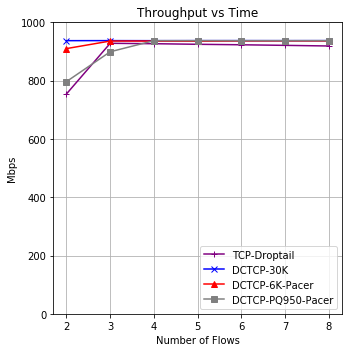

In [49]:

plot_labels = ["TCP-Droptail", "DCTCP-30K", "DCTCP-6K-Pacer", "DCTCP-PQ950-Pacer"]
markers = ["+","x","^","s"]
colors = ["purple", "blue", "red", "gray"]
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
for i,lbel in enumerate(plot_labels):
    ax1.plot(nums_flows, throughput_results[i,:], label=lbel, marker=markers[i], color=colors[i]) 
ax1.set_title("Throughput vs Time")
ax1.legend(loc='lower right')
ax1.set_ylabel('Mbps')
ax1.set_xlabel('Number of Flows')
ax1.grid(which='major', linestyle="-")
ax1.grid(which='minor', linestyle='--')
ax1.set_ylim(bottom=0, top=1000)

fig.tight_layout()   

fig.savefig("throughput final.png", format="png")
fig.show()

In [50]:
def plot_delays(x,y,yerr=None):
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    #ax1.plot(x, y, label="Delay") 
    
    for i,lbel in enumerate(plot_labels):
        filler = np.zeros(shape=(yerr.shape[1],1))
        yerr_tmp = yerr[i,:] - y[i,:]
        yerr_tmp=np.concatenate((filler, yerr_tmp.reshape(yerr.shape[1],1)), axis=1).T
#         print(y[i,:])
#         print(yerr_tmp)
#         print("-----------------")
        ax1.errorbar(x, y[i,:], yerr=yerr_tmp, fmt='none', capsize=2, color = colors[i])
        ax1.semilogy(x, y[i,:], label=lbel, marker=markers[i], color = colors[i])
    ax1.set_title("Delay vs Time")
    ax1.legend(loc='lower right')
    
    ax1.set_ylabel('us')
    ax1.set_xlabel('Number of Flows')
    ax1.grid(which='major', linestyle="-")
    ax1.grid(which='minor', linestyle='--')

    fig.tight_layout()  
    fig.show()

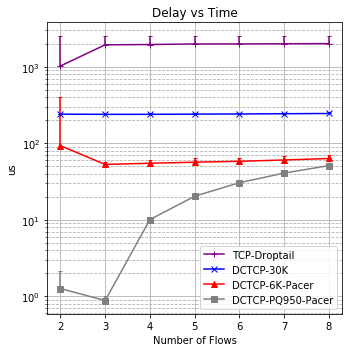

In [51]:
plot_delays(nums_flows, delay_results, delay_results_99)

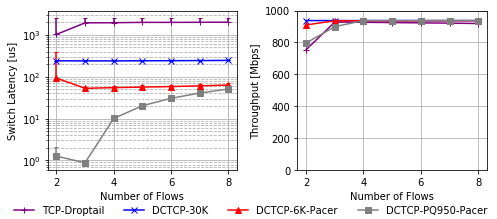

In [52]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
#ax1.plot(x, y, label="Delay") 

for i,lbel in enumerate(plot_labels):
    filler = np.zeros(shape=(delay_results_99.shape[1],1))
    yerr_tmp = delay_results_99[i,:] - delay_results[i,:]
    yerr_tmp=np.concatenate((filler, yerr_tmp.reshape(delay_results_99.shape[1],1)), axis=1).T
    ax1.errorbar(nums_flows, delay_results[i,:], yerr=yerr_tmp, fmt='none', capsize=2, color = colors[i])
    ax1.semilogy(nums_flows, delay_results[i,:], label=lbel, marker=markers[i], color = colors[i])
#ax1.set_title("Switch Latency")
#ax1.legend(loc='lower right')

ax1.set_ylabel('Switch Latency [us]')
ax1.set_xlabel('Number of Flows')
ax1.grid(which='major', linestyle="-")
ax1.grid(which='minor', linestyle='--')

for i,lbel in enumerate(plot_labels):
    ax2.plot(nums_flows, throughput_results[i,:], label=lbel, marker=markers[i], color=colors[i]) 
#ax2.set_title("Aggregate Throughput")
#ax2.legend(loc='lower right')
ax2.set_ylabel('Throughput [Mbps]')
ax2.set_xlabel('Number of Flows')
ax2.grid(which='major', linestyle="-")
ax2.grid(which='minor', linestyle='--')
ax2.set_ylim(bottom=0, top=1000)

handles, labels = ax2.get_legend_handles_labels()

fig.legend(handles, labels, loc= (0.02,0), ncol=4, fancybox=False,frameon=False)
fig.subplots_adjust(bottom = 0.3)
fig.tight_layout()  
fig.show()